In [56]:
# import libraries
%matplotlib inline
import sys
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from ggplot import *
from sklearn.neighbors import KernelDensity
import notebook_library as lib
from sklearn.model_selection import GridSearchCV
import scipy.stats as st
import sklearn

#help(lib)

In [58]:
sgd = lib.open_sgd(600)

In [22]:
# I exclude the chromosome 17 or mitochondrial as well as others like 2u from a plasmid?
sgd = sgd[sgd.chromosome.isin(map(str,range(1,17)))]

In [23]:
# Find the closest promoter-centers to each of the promoter-centers in SGD 
# One per-chromosome !!!
dist_total = []
for i in range(1,17):
    s_i=str(i)    
    nbs = NearestNeighbors(n_neighbors=5,algorithm='ball_tree',).fit(sgd[sgd.chromosome==s_i]['promoter_median'].values.reshape(-1,1))
    # and split the results into distances and indices.
    distances, indices = nbs.kneighbors(sgd[sgd.chromosome==s_i]['promoter_median'].values.reshape(-1,1))

    # Each row in indices have the key of the gene in SGD and of the closest (promoter) genes
    # and these are the distances between the center of the promoter and the center-promoter of the closest promoters
    for j in distances.astype(int):
        dist_total.append(j)

In [24]:
# Extrapolate number of overlapping promoter from the length in bp of the promoters
x,y = [],[]
for promoter_length in range(0,2100,50):           #(0,2100,50):
    count=0
    for row in dist_total:
        for i in row[1:]:
            if i<promoter_length:
                count+=1
                break

    x.append(promoter_length)
    y.append(count)

In [11]:
df = pd.DataFrame(zip(x,y), columns = ['promoter_length','overlapping_promoters'])

/home/ariel/.local/lib/python2.7/site-packages/ggplot/ggplot.py:192: RuntimeWarning: Setting "mpl.rcParams['axes.prop_cycle']=cycler(u'color', [u'#333333', u'#348ABD', u'#7A68A6', u'#A60628', u'#467821', u'#CF4457', u'#188487', u'#E24A33'])" raised an Exception: u'axes.prop_cycle is not a valid rc parameter.See rcParams.keys() for a list of valid parameters.'
  warnings.warn(msg, RuntimeWarning)


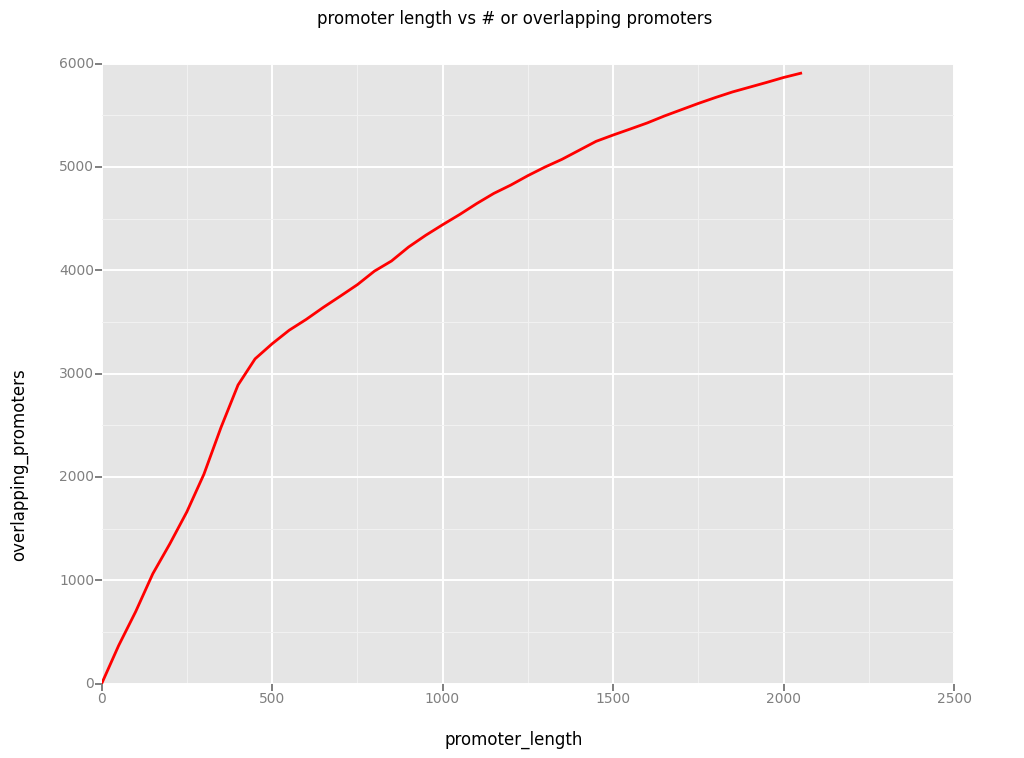

<ggplot: (8748929890649)>

In [12]:
ggplot(aes(x='promoter_length', y='overlapping_promoters'),data=df) + geom_line(size=2, color='red') + ggtitle('promoter length vs # or overlapping promoters')

In [9]:
# wig_file to be used
wig14, w_pointer14 = lib.open_wig('./extremes_14.wig')
wig27, w_pointer27 = lib.open_wig('./extremes_27.wig')

['variableStep chrom=chrI']
['variableStep chrom=chrII']
['variableStep chrom=chrIII']
['variableStep chrom=chrIV']
['variableStep chrom=chrV']
['variableStep chrom=chrVI']
['variableStep chrom=chrVII']
['variableStep chrom=chrVIII']
['variableStep chrom=chrIX']
['variableStep chrom=chrX']
['variableStep chrom=chrXI']
['variableStep chrom=chrXII']
['variableStep chrom=chrXIII']
['variableStep chrom=chrXIV']
['variableStep chrom=chrXV']
['variableStep chrom=chrXVI']
['variableStep chrom=chrI']
['variableStep chrom=chrII']
['variableStep chrom=chrIII']
['variableStep chrom=chrIV']
['variableStep chrom=chrV']
['variableStep chrom=chrVI']
['variableStep chrom=chrVII']
['variableStep chrom=chrVIII']
['variableStep chrom=chrIX']
['variableStep chrom=chrX']
['variableStep chrom=chrXI']
['variableStep chrom=chrXII']
['variableStep chrom=chrXIII']
['variableStep chrom=chrXIV']
['variableStep chrom=chrXV']
['variableStep chrom=chrXVI']


65.5517241379
area =  33937.6976903   65.5517241379   -1
variance:  [ 11892.20968193     84.13110765] 
skewness:  [ 0.06249052 -0.12313991] 
kurtosis:  [-1.10970168 -1.00859707]


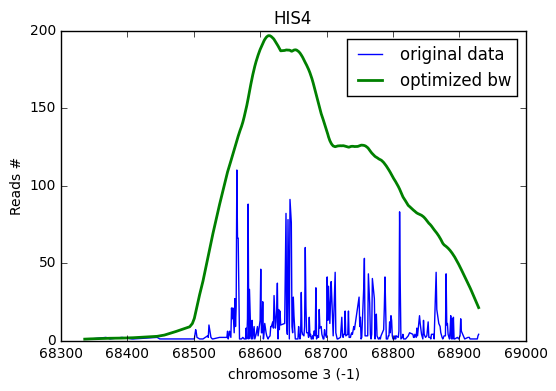

In [229]:
# test a single gene
gene2Test = 'HIS4'

# retrieve positions 
gene_df = lib.retrieve_positions(sgd[sgd.gene==gene2Test].index[0], sgd, wig14, w_pointer14)

if len(gene_df)>0:
    # extract x and y form the matrix Gene_df
    x,y = np.array(gene_df.position).astype(int), np.array(gene_df.reads).astype(int)

# when there is some signal, model the probability function and calculate the AUC.
if len(x)>0 and len(y)>0 and np.sum(i)>50:
    #pdf = lib.kernelPDF(x, y, bandwidth=72)
    #area = np.trapz(pdf, dx=5)
    
    # Prepare "histogram-like" data
    histo = []
    for i in range(len(y)):
        for j in range(y[i]):
            histo.append(x[i])
    histo = np.array(histo)
            
    
    #Check which is the best bandwidth to use with 20 steps of cross-validation
#    grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.1,100,30)}, cv=20)
#    grid.fit(histo[:,None])
    
#    best = grid.best_params_.values()[0]
    print best
    pdf = lib.kernelPDF(x, y, bandwidth=best)
    stats = st.describe(np.array([i for i in zip(x,pdf) if i[1]>5]))
    variance, skewness, kurtosis = stats[3:6]
    stat_plot = np.array([i for i in zip(x,pdf) if i[1]>5])
#    plt.plot(stat_plot[:,0], stat_plot[:,1]*3, label='peak description')        
    print "area = ",area," ",best," ",sgd[sgd.gene==gene2Test]['W/C'][0]
    plt.plot(x,y, label='original data')
#    stats = st.describe(skewArray) 
    print "variance: ",variance,"\n","skewness: ",skewness,"\n","kurtosis: ",kurtosis
    
        
    
    
    plt.plot(x,pdf*5, label='optimized bw', linewidth=2)
#    plt.plot(x,lib.kernelPDF(x, y, bandwidth=30)*5, label='ligtly smoothed')
    plt.xlabel(''.join(['chromosome ',str(int(sgd[sgd.gene==gene2Test].chromosome)),' (',str(sgd[sgd.gene==gene2Test]['W/C'][0]),")"]))
    plt.ylabel('Reads #')
    plt.legend(loc='upper right')
    plt.title(gene2Test)

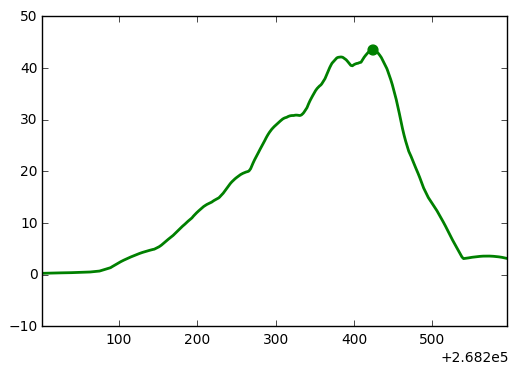

In [221]:
# Now that I know the best value to use as bandwidth, I plot a \
# range within this value to show how it differs with different parameter

best_plusMinus = [int(best-30),int(best),int(best+30)]

pdf_all = []
for i in best_plusMinus:
    pdf = lib.kernelPDF(x, y, bandwidth=i)
    pdf_all.append(pdf)
#pdf_all.append(y)

m = pd.DataFrame(pdf_all).T
m.set_index(x, inplace=True)
m.columns = best_plusMinus
m['original data'] = y  

# With this I can find the peak or peaks.
series = np.asmatrix(m)[:,1]  # choosing the axis 0,1 or 2 I can test the different bw models.
x = np.array(m.index)
maxtab, mintab = lib.peakdet(series,10,x)
plt.plot(x,series, color='green', linewidth=2)
plt.xlim([np.min(x),np.max(x)])
plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='green', s=50)

In [58]:
# area and counts columns added to the sgd dataframe
sgd['area'] = [0 for i in range(len(sgd))]
sgd['counts'] = [0 for i in range(len(sgd))]

# go over all loci
for i in sgd.itertuples():
    
    # retrieve positions 
    gene_df = lib.retrieve_positions(i.Index, sgd, wig14, w_pointer14)
    if len(gene_df)>0:
        
    # extract x and y form the matrix Gene_df
    x,y = np.array(gene_df.position).astype(int), np.array(gene_df.reads).astype(int)
    
    # I fill the column for total counts
    sgd.loc[i.Index,'counts'] = np.sum(y)
    
    # when there is some signal, model the probability function and calculate the AUC.
    if len(x)>0 and len(y)>0:
        pdf = lib.kernelPDF(x, y, bandwidth=50)
        area = np.trapz(pdf, dx=5)
        sgd.loc[i.Index,'area'] = area


gene                NaN
chromosome           16
start               643
stop               1125
W/C                   1
start_promoter       43
promoter_median     343
area                  0
counts                0
Name: YPL283W-B, dtype: object   Empty DataFrame
Columns: []
Index: []


counts:  634.76487597   +-  1518.94440473 
area:  3728.10301487  +-  4663.01218998


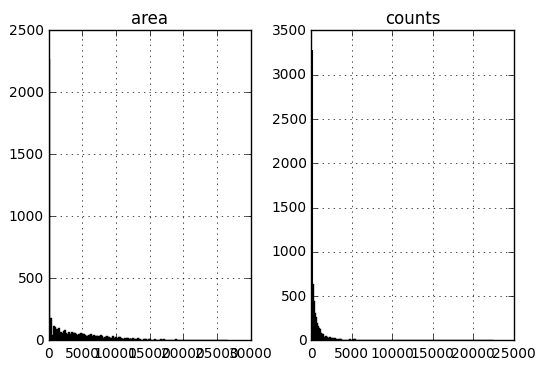

In [37]:
# Check distribution of areas and count
sgd[['area','counts']].hist(bins=200)
#gene_df = lib.retrieve_positions('YAL086W-A', sgd, wig, w_pointer)
#x,y = np.array(gene_df.position).astype(int), np.array(gene_df.reads).astype(int)
#print ggplot(aes(x='area'),data=sgd) + geom_histogram(binwidth=250, color='red') + ggtitle('peak areas distribution')
#print ggplot(aes(x='counts'),data=sgd) + geom_histogram(binwidth=250, color='red') + ggtitle('peak areas distribution')
print "counts: ",np.mean(sgd.sort_values(['area'], ascending=False).counts)," ",\
      "+- ",np.std(sgd.sort_values(['area'], ascending=False).counts),"\n",\
      "area: ",np.mean(sgd.area)," +- ", np.std(sgd.area)

#ggplot
#lib.ggplotIt(x,y,pdf)
#x = np.array(sgd.area)
#plt.hist(x, bins=200)

[[ 1.          0.81863536]
 [ 0.81863536  1.        ]]


/usr/local/lib/python2.7/dist-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


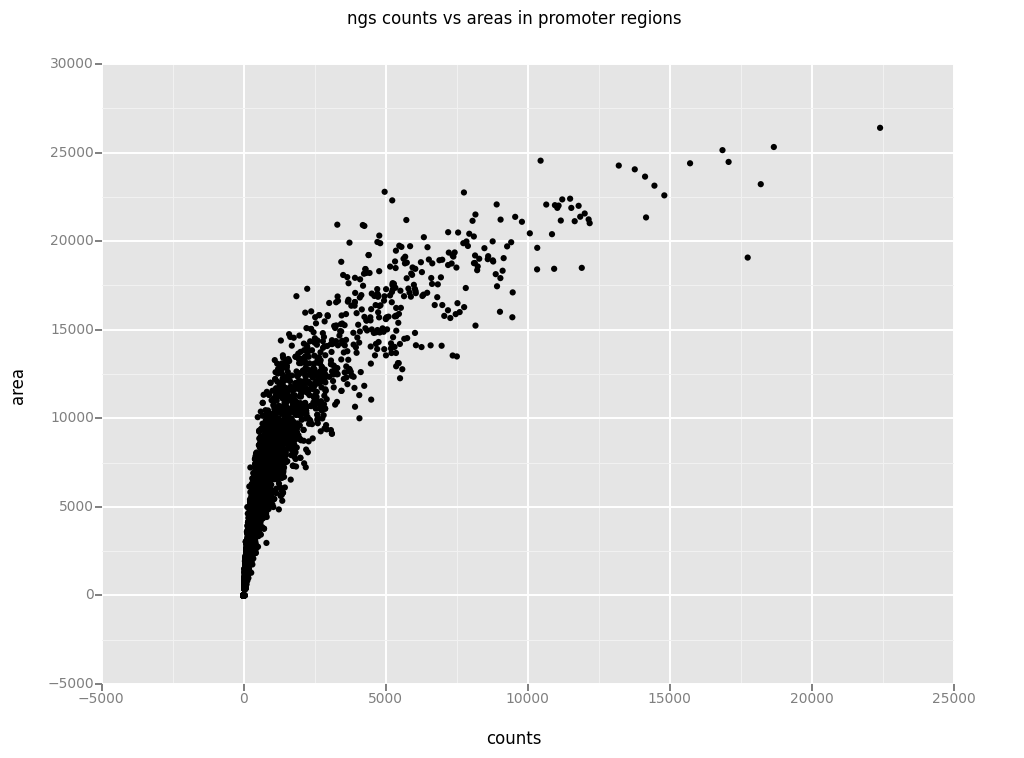

<ggplot: (8789019054837)>

In [38]:
sgd.sort_values(['counts'], ascending=False)
x,y = np.array(sgd.counts),np.array(sgd['area'])
print np.corrcoef(x,y)
ggplot(aes('counts','area'), data=sgd) + geom_point() +ggtitle('ngs counts vs areas in promoter regions')#+ scale_y_log(10)

In [201]:
# Here we checked that once I can work on the server, I can evaluate the best bandwidth to use with the kernel density function

# retrieve info for the gene 
gene_df = lib.retrieve_positions(sgd[sgd.gene=='ARG3'].index[0], sgd, wig14, w_pointer14)
x,y = np.array(gene_df.position).astype(int), np.array(gene_df.reads).astype(int)

# Prepare "histogram-like" data
histo = []
for i in range(len(y)):
	for j in range(y[i]):
		histo.append(x[i])
histo = np.array(histo)

#Check which is the best bandwidth to use with 20 steps of cross-validation
grid = GridSearchCV(KernelDensity(),{'bandwidth': np.linspace(0.1,100,30)}, cv=20)
grid.fit(histo[:,None])

best = grid.best_params_.values()[0]
best_plusMinus = [best-10,best,best+10]

pdf_all = []
for i in best_plusMinus:
    pdf = lib.kernelPDF(x, y, bandwidth=i)  

KeyboardInterrupt: 

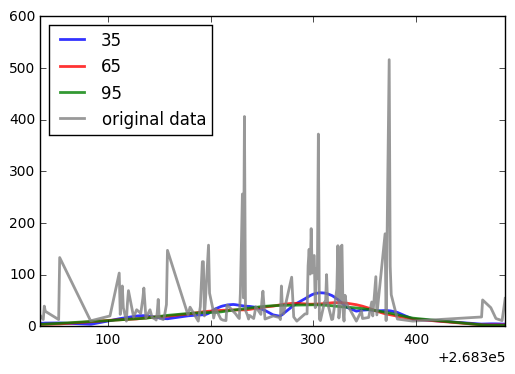

In [40]:
# Now that I know the best value to use as bandwidth, I plot a \
# range within this value to show how it differs with different parameter

best = grid.best_params_.values()[0]
best_plusMinus = [int(best-30),int(best),int(best+30)]

pdf_all = []
for i in best_plusMinus:
    pdf = lib.kernelPDF(x, y, bandwidth=i)
    pdf_all.append(pdf)
#pdf_all.append(y)

m = pd.DataFrame(pdf_all).T
m.set_index(x, inplace=True)
m.columns = best_plusMinus
m['original data'] = y  

#plt.figure()
#plt.plot(m['original data'], linewidth=0.5)
#plt.plot(m[best_plusMinus], linewidth=2)
m.plot(linewidth=2, alpha=0.8, color = ['b','r','g','grey'])

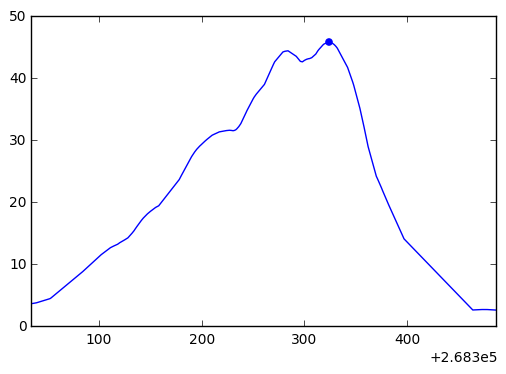

In [41]:
# With this I can find the peak or peaks.
series = np.asmatrix(m)[:,1]  # choosing the axis 0,1 or 2 I can test the different bw models.
x = np.array(m.index)
maxtab, mintab = lib.peakdet(series,10,x)
plt.plot(x,series)
plt.xlim([np.min(x),np.max(x)])
plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')

[ 268533.  268602.  268671.]


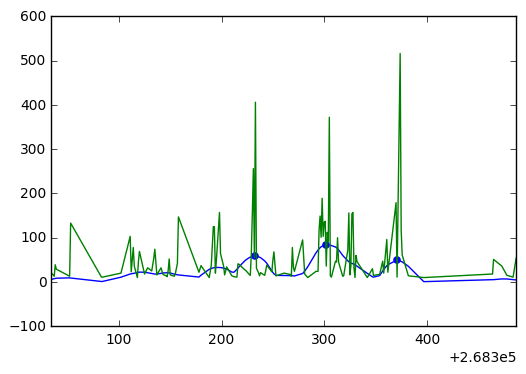

In [42]:
# Check if using a bw<10 I can get a full number of peaks
series = lib.kernelPDF(x, y, bandwidth=20)
#pdf_df = pd.DataFrame(pdf)
#series = np.array(pdf_df)[:,0]
maxtab, mintab = lib.peakdet(series,30,x)
plt.plot(x,series)
plt.plot(x,y)
plt.xlim([np.min(x),np.max(x)])
print maxtab[:,0]
plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')

array([], dtype=int64)

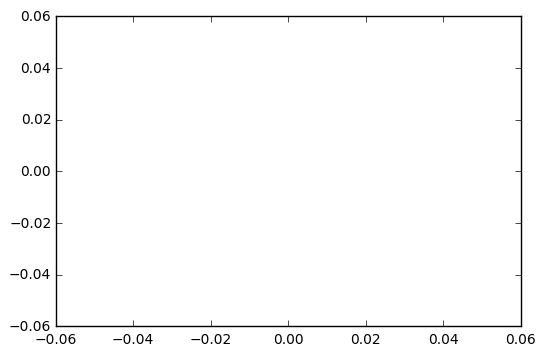

In [43]:
gene_df = lib.retrieve_positions('YAL068W-A', sgd, wig, w_pointer)
x,y = np.array(gene_df.position).astype(int), np.array(gene_df.reads).astype(int)

plt.plot(x,y)
x

In [44]:
sgd[sgd.gene=='ARG3']

,gene,chromosome,start,stop,W/C,start_promoter,promoter_median,area,counts
locus,,,,,,,,,
YJL088W,ARG3,10,268799.0,269815.0,1,268199,268499,19885.218585,7732


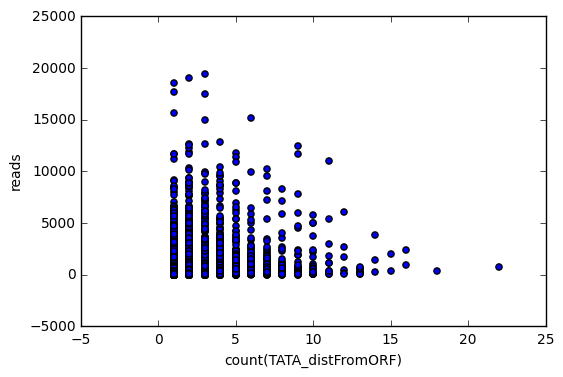

In [282]:
tatas_max = pd.read_csv('tatas_num.csv')
wig_counts = pd.read_csv('wig_counts.csv')

t_max = tatas_max[['id','count(TATA_distFromORF)']]
t_max = t_max.set_index(['id'])

w_counts = wig_counts[['id','reads']]
w_counts = w_counts.set_index(['id'])

tataVSreads = pd.concat([w_counts,t_max], axis=1)
results = tataVSreads.dropna()
results.plot.scatter(y='reads',x='count(TATA_distFromORF)')

In [157]:
gcn4_motifs = pd.read_csv('gcn4_motifs.csv')

In [158]:
gcn4_motifs = gcn4_motifs[['id','motif','distFromORF']]

In [159]:
len(gcn4_motifs[(gcn4_motifs.motif=='TGACTCA') & (gcn4_motifs.id=='YCL030C')])

1

In [160]:
mtfs = ['TGACTCA', 'ATGACTC', 'TGACTAA', 'GTGACTC', 'TATGACT', 'ATGACTA', 'ATGACTG', 'GACTCAT', 'GATGACT', 'ATGACAC']
for i in mtfs:
    sgd[i] = [0 for j in range(len(sgd))]
    
    for j in sgd.itertuples():
        q = len(gcn4_motifs[(gcn4_motifs.motif==i) & (gcn4_motifs.id==j.Index)])
        sgd.loc[j.Index,i] = q

In [162]:
cluster = np.array(sgd[mtfs])

,gene,chromosome,start,stop,W/C,start_promoter,promoter_median,TGACTCA,ATGACTC,TGACTAA,GTGACTC,TATGACT,ATGACTA,ATGACTG,GACTCAT,GATGACT,ATGACAC
locus,,,,,,,,,,,,,,,,,
YAL068W-A,NaN,1,538.0,792.0,1,0,269,0,0,0,0,0,0,0,0,0,0
YAL068C,PAU8,1,2169.0,1807.0,-1,2769,2469,0,0,0,0,0,0,0,0,0,0
YAL067W-A,NaN,1,2480.0,2707.0,1,1880,2180,0,0,0,0,0,0,0,0,0,0
YAL067C,SEO1,1,9016.0,7235.0,-1,9616,9316,0,0,0,0,0,0,0,0,0,1
YAL066W,NaN,1,10091.0,10399.0,1,9491,9791,0,0,0,0,0,0,0,0,0,0


In [145]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(cluster)
kmeans.labels_

array([0, 0, 0, ..., 0, 1, 0], dtype=int32)

In [146]:
kmeans.cluster_centers_

array([[  2.46732026e-02,   1.89542484e-02,   2.30392157e-02,
          1.43790850e-02,   2.15686275e-02,   3.56659147e-15,
          1.83006536e-02,   2.50000000e-02,   7.00134395e-15,
          3.03921569e-02],
       [  5.76496674e-02,   1.48558758e-01,   2.03991131e-01,
          2.21729490e-02,   1.70731707e-01,   5.67627494e-01,
          1.39689579e-01,   2.88248337e-02,   6.07538803e-01,
          3.32594235e-02]])

['TGACTCA', 120, 173]
['ATGACTC', 119, 176]
['TGACTAA', 106, 231]
['GTGACTC', 46, 96]
['TATGACT', 149, 207]
['ATGACTA', 194, 252]
['ATGACTG', 110, 173]
['GACTCAT', 73, 165]
['GATGACT', 181, 267]
['ATGACAC', 42, 198]


/home/ariel/.local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


'\nfor i in mtfs:\n    print i, len(mot[mot[i]>0])\n\n\nprint "\ncluster 0 ",len(mot[mot.cluster==0]),"\n",mot[mot.cluster==0].sum()\nprint "\ncluster 1 ",len(mot[mot.cluster==1]),"\n",mot[mot.cluster==1].sum()\n\nmot.hist(\'number\',figsize=(3,3))\nmot[mot.cluster==1].hist() #plot.scatter(x=X, y=Y)\nmot[mot.cluster==0].hist() #plot.scatter(x=X, y=Y)\n\nfor i in mtfs:\n    print mot[mot[i]>1]\n'

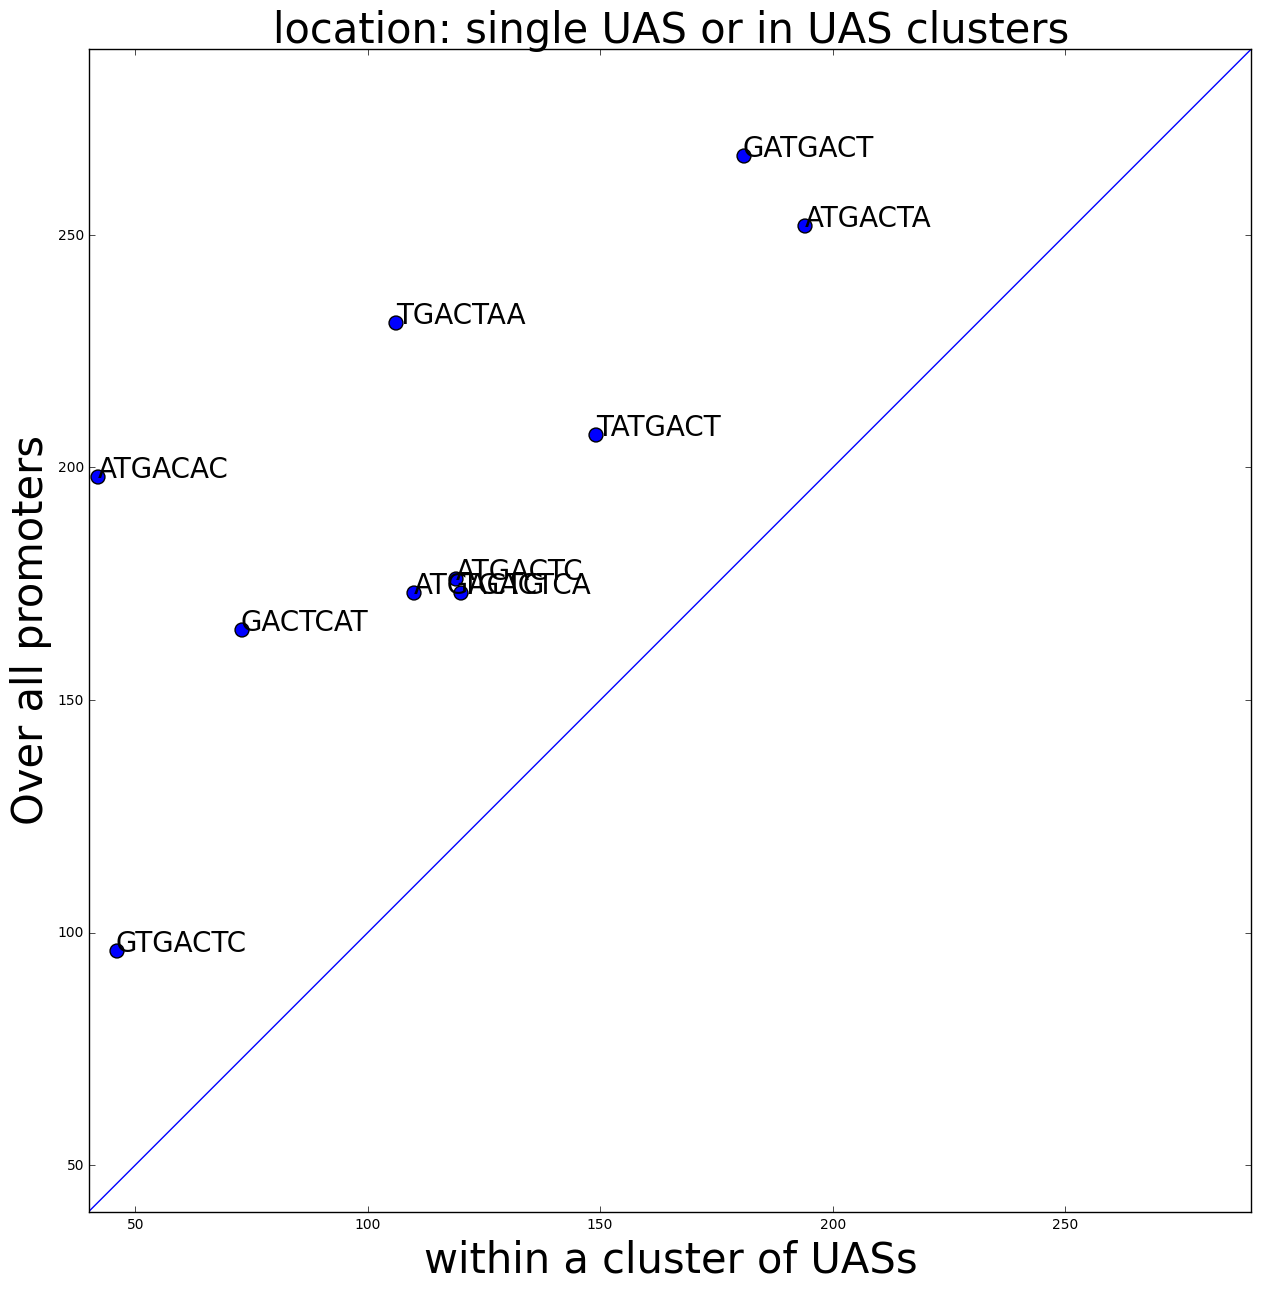

In [325]:
mot = sgd[mtfs]
#mot['cluster'] = kmeans.labels_     

mot['number'] = [mot.loc[i.Index].sum() for i in mot.itertuples()]

X = 'TGACTCA'
Y = 'number'


#print mot[mot.number>1].number.max()
matriz= []
for i in mtfs:
    matriz.append([i, len(mot[(mot.number>1) & (mot[i]>0)]), len(mot[mot[i]>0])])

   
for i in matriz:
    print i
matriz = np.array(matriz)

plt.figure(figsize=(15,15))
plt.scatter(matriz[:,1],matriz[:,2],s=100)
plt.plot([40,290],[40,290])
for i,txt in enumerate(matriz[:,0]):
    plt.annotate(txt, (matriz[i,1],matriz[i,2]), fontsize=20)
plt.xlabel('within a cluster of UASs', fontsize=30)
plt.ylabel('Over all promoters',fontsize=30)
plt.xlim(40,290)
#plt.xlim(100,140)
plt.ylim(40,290)
#plt.ylim(170,180)
plt.title('location: single UAS or in UAS clusters', fontsize=30)
# Agregar al plot el color segun el count number de cada point !!

#print mot.sum(),"\n"

'''
for i in mtfs:
    print i, len(mot[mot[i]>0])


print "\ncluster 0 ",len(mot[mot.cluster==0]),"\n",mot[mot.cluster==0].sum()
print "\ncluster 1 ",len(mot[mot.cluster==1]),"\n",mot[mot.cluster==1].sum()

mot.hist('number',figsize=(3,3))
mot[mot.cluster==1].hist() #plot.scatter(x=X, y=Y)
mot[mot.cluster==0].hist() #plot.scatter(x=X, y=Y)

for i in mtfs:
    print mot[mot[i]>1]
'''

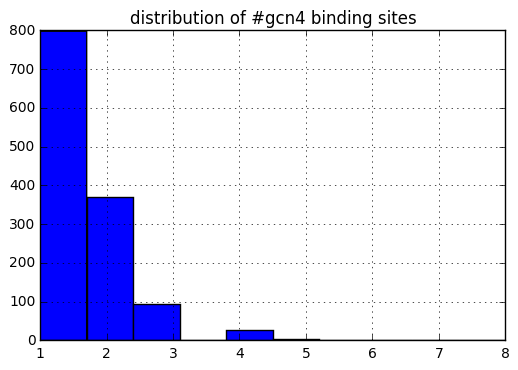

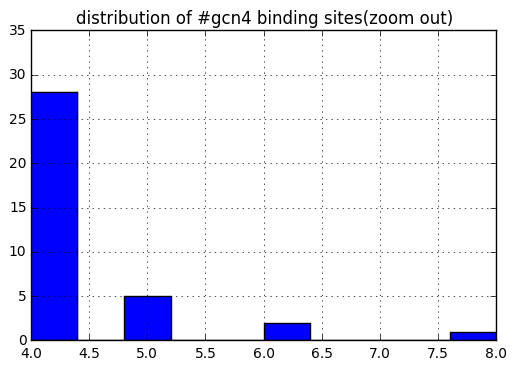

In [258]:
mot[mot.number>0].number.hist()
plt.title('distribution of #gcn4 binding sites')
plt.show()
mot[mot.number>3].number.hist()
plt.ylim(0,35)
plt.title('distribution of #gcn4 binding sites(zoom)')
plt.show()

In [193]:
np.array(wig14.reads).astype(int).sum()

6525194

0.895859648004


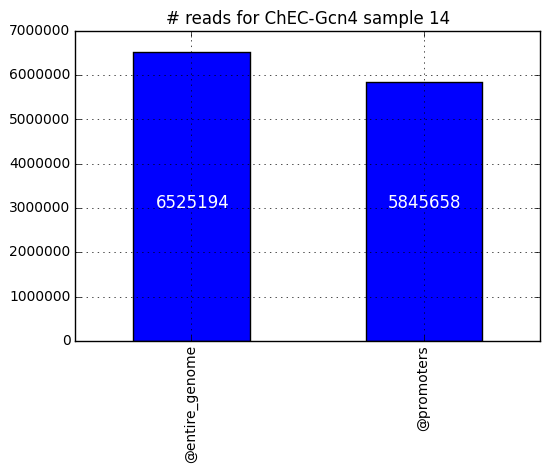

In [366]:
print (5845658.0/6525194.0)
tabla = {'@entire_genome':6525194.0, '@promoters':5845658.0 }
plt.figure()
pd.Series(tabla).plot.bar(grid=True)
plt.annotate('5845658', (0.85,3000000), color='white', size=12)
plt.annotate('6525194', (-0.15,3000000), color='white', size=12)
plt.title('# reads for ChEC-Gcn4 sample 14')

In [276]:
np.array(wig27.reads).astype(int).sum()

6989146

0.921419011708


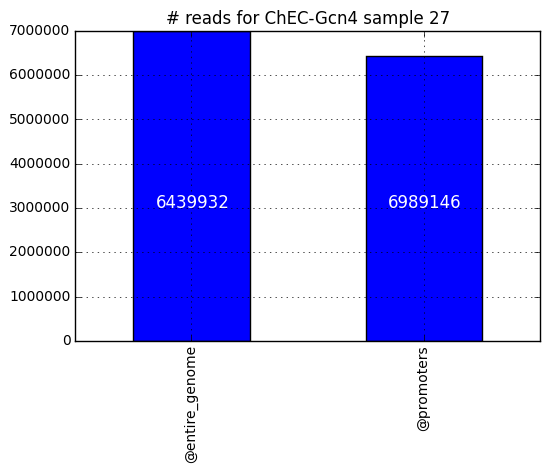

In [280]:
print 6439932.0/6989146.0

tabla = {'@entire_genome':6989146.0, '@promoters':6439932.0 }
plt.figure()
pd.Series(tabla).plot.bar(grid=True)
plt.annotate('6439932', (-0.15,3000000), color='white', size=12)
plt.annotate('6989146', (0.85,3000000), color='white', size=12)
plt.title('# reads for ChEC-Gcn4 sample 27')

In [306]:
totals = pd.read_csv('wig_totals.csv')
totals = totals.set_index(['id'])

In [379]:
# cuando calculo la diff. normalizo las reads por las reads de todo el genoma.
totals['area_diff'] = [int(totals.loc[i.Index].area_14)/6.525194 - \
                       int(totals.loc[i.Index].area_27)/6.439932 for i in totals.itertuples()]

totals['reads_diff'] = [int(totals.loc[i.Index].reads_14)/6.525194 - \
                       int(totals.loc[i.Index].reads_27)/6.439932 for i in totals.itertuples()]


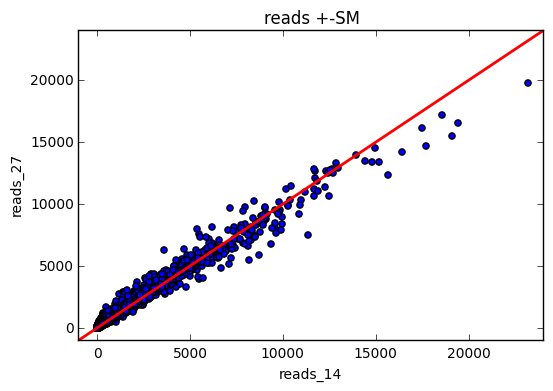

In [380]:
totals.plot.scatter(x='reads_14', y='reads_27')
plt.plot([-1000,24000],[-1000,24000], linewidth=2, color='r')
plt.ylim(-1000,24000)
plt.xlim(-1000,24000)
plt.title('reads +-SM')

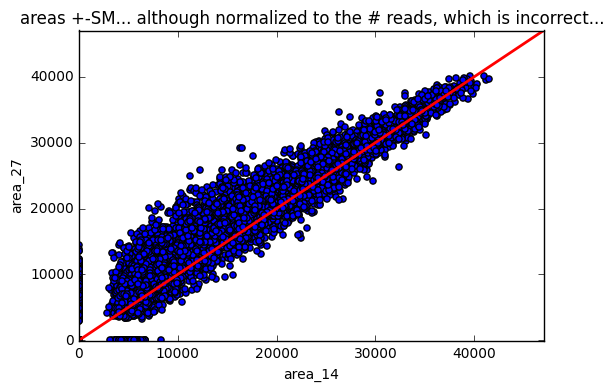

In [385]:
totals.plot.scatter(x='area_14',y='area_27')
plt.plot([-10,47000],[-10,47000], linewidth=2, color='r')
plt.ylim(-10,47000)
plt.xlim(-10,47000)
plt.title('areas +-SM... although normalized to the # reads, which is incorrect...')

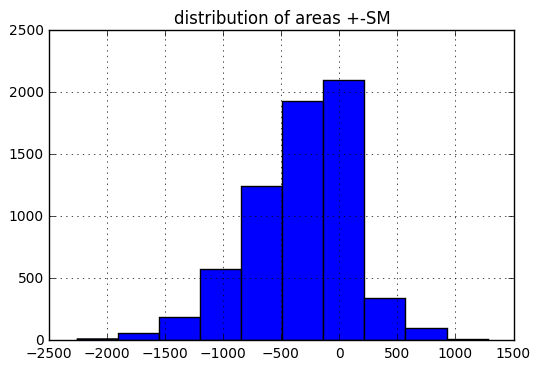

In [381]:
totals.area_diff.hist()
plt.title('distribution of areas +-SM')

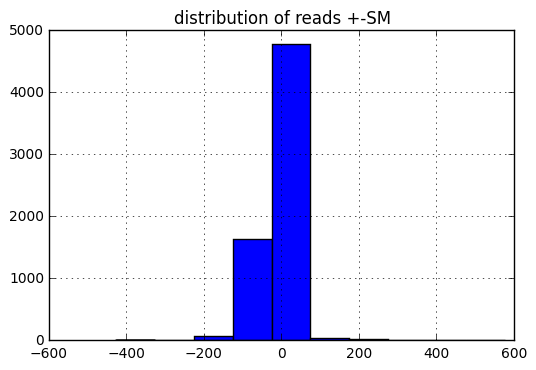

In [382]:
totals.reads_diff.hist()
plt.title('distribution of reads +-SM')

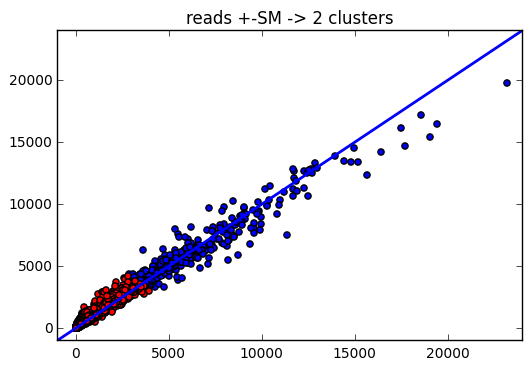

In [417]:
#clustering into 2 clusters

cluster = np.array(totals[['reads_14','reads_27']])
kmeans = KMeans(n_clusters=2).fit(cluster)
totals['cluster'] = kmeans.labels_

plots = np.array(totals[['reads_14','reads_27']])
LABEL_COLOR_MAP = {0:'r', 1:'b'}
label_color = [LABEL_COLOR_MAP[l] for l in np.array(totals.cluster)]
for i in range(len(plots)):
    plt.scatter(plots[i,0],plots[i,1], c=label_color[i])

plt.plot([-1000,24000],[-1000,24000], linewidth=2, c='b')
plt.ylim(-1000,24000)
plt.xlim(-1000,24000)
plt.title('reads +-SM -> 2 clusters')


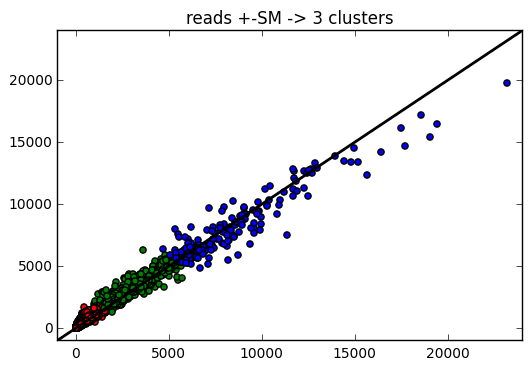

In [420]:
#clustering into 3 clusters

cluster = np.array(totals[['reads_14','reads_27']])
kmeans = KMeans(n_clusters=3).fit(cluster)
totals['cluster'] = kmeans.labels_

plots = np.array(totals[['reads_14','reads_27']])
LABEL_COLOR_MAP = {0:'r', 1:'b', 2:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in np.array(totals.cluster)]
for i in range(len(plots)):
    plt.scatter(plots[i,0],plots[i,1], c=label_color[i])

plt.plot([-1000,24000],[-1000,24000], linewidth=2, c='k')
plt.ylim(-1000,24000)
plt.xlim(-1000,24000)
plt.title('reads +-SM -> 3 clusters')


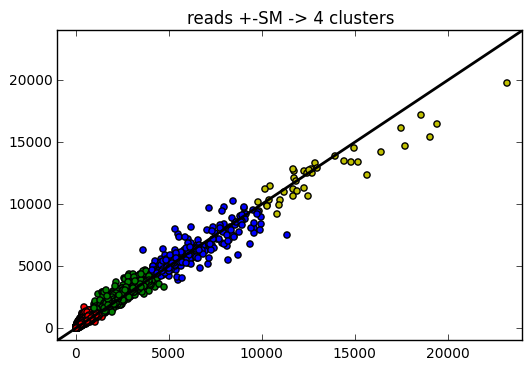

In [421]:
#clustering into 4 clusters

cluster = np.array(totals[['reads_14','reads_27']])
kmeans = KMeans(n_clusters=4).fit(cluster)
totals['cluster'] = kmeans.labels_

plots = np.array(totals[['reads_14','reads_27']])
LABEL_COLOR_MAP = {0:'r', 1:'b', 2:'g', 3:'y'}
label_color = [LABEL_COLOR_MAP[l] for l in np.array(totals.cluster)]
for i in range(len(plots)):
    plt.scatter(plots[i,0],plots[i,1], c=label_color[i])

plt.plot([-1000,24000],[-1000,24000], linewidth=2, c='k')
plt.ylim(-1000,24000)
plt.xlim(-1000,24000)
plt.title('reads +-SM -> 4 clusters')


In [472]:
R = np.corrcoef(np.array(totals.reads_diff),np.array(totals.area_diff))

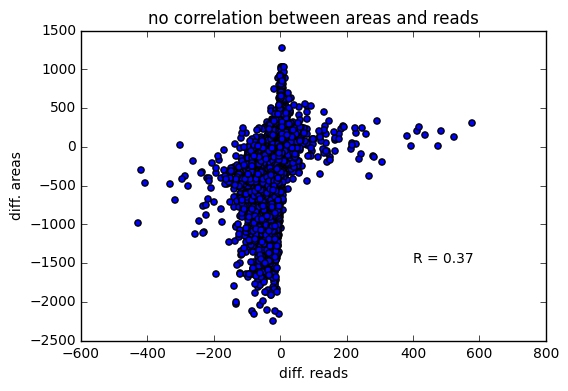

In [475]:
m = np.array(zip(np.array(totals.reads_diff),np.array(totals.area_diff)))
plt.scatter(m[:,0],m[:,1])
plt.xlabel('diff. reads')
plt.ylabel('diff. areas')
plt.title('no correlation between areas and reads')
r = '%.2f' %R[1][0]
plt.annotate(''.join(['R = ',str(r)]),(400,-1500))

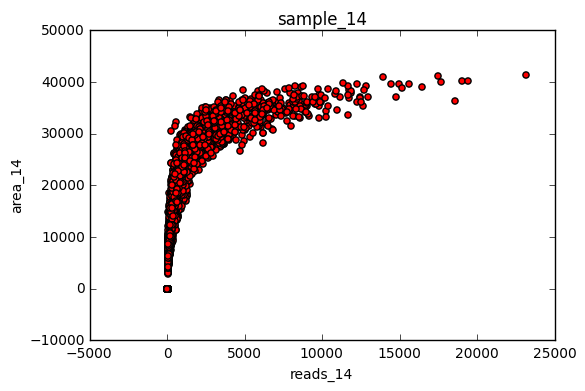

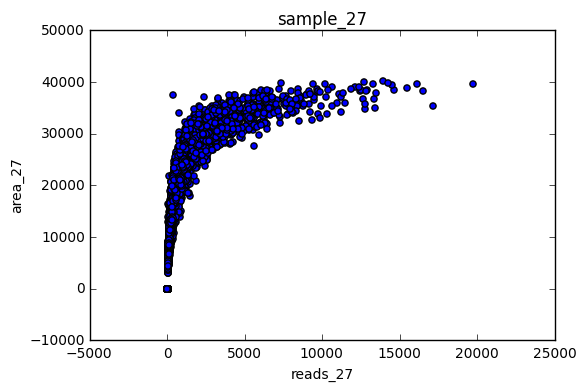

In [483]:
plt.figure()
totals.plot.scatter(x='reads_14', y='area_14', c='r')
plt.title('sample_14')
totals.plot.scatter(x='reads_27', y='area_27', c='b')
plt.title('sample_27')

In [156]:
peak_areas.head()

,area
id,
YAL068W-A,11037.893038
YAL068C,3126.290909
YAL067W-A,1698.518182
YAL067C,17941.201136
YAL066W,3763.377000


In [296]:
tss = pd.read_csv('tss.csv')
tss = tss[['id','TSS_start']]
tss.set_index(['id'], inplace=True)

best_AUC = pd.read_csv('wig_best_AUC_positions.csv')
best_AUC = best_AUC[['id','best_AUC_positions']]
best_AUC.set_index(['id'], inplace=True)

peak_areas = pd.read_csv('peak_areas.csv')
peak_areas.columns = ['id', 'area']
peak_areas.set_index(['id'], inplace=True)

tatas_avg = pd.read_csv('tatas_avg.csv')
tatas_avg = tatas_avg[['id','avg(TATA_distFromORF)']]
tatas_avg.set_index(['id'], inplace=True)

tatas_num = pd.read_csv('tatas_num.csv')
tatas_num = tatas_num[['id','count(TATA_distFromORF)']]
tatas_num.set_index(['id'], inplace=True)

gcn4_BS_num = pd.read_csv('gcn4_BS_num.csv')
gcn4_BS_num = gcn4_BS_num[['id','count(gcn4_binding_sites_distFromORF)']]
gcn4_BS_num.columns = ['id','count']
gcn4_BS_num.set_index(['id'], inplace=True)

gcn4_BS_min = pd.read_csv('gcn4_BS_min.csv')
gcn4_BS_min = gcn4_BS_min[['id','min(gcn4_binding_sites_distFromORF)']]
gcn4_BS_min.columns = ['id','min']
gcn4_BS_min.set_index(['id'], inplace=True)

gcn4_BS_max = pd.read_csv('gcn4_BS_max.csv')
gcn4_BS_max = gcn4_BS_max[['id','max(gcn4_binding_sites_distFromORF)']]
gcn4_BS_max.columns = ['id','max']
gcn4_BS_max.set_index(['id'], inplace=True)

wig_counts = pd.read_csv('wig_totals.csv')
wig_counts = wig_counts[['id','area_14','reads_14','area_27','reads_27']]
wig_counts.set_index(['id'], inplace=True)


In [381]:
#mix = pd.concat([tss,best_AUC,peak_areas,tatas_avg,tatas_num], axis=1)
#mix = mix.dropna()
#print wig_counts['reads_14'].sum()
#print len(tss), len(best_AUC), len(peak_areas), len(tatas_avg), len(tatas_num), len(gcn4_BS_num), len(gcn4_BS_min), len(gcn4_BS_max), len(wig_counts)
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(wig_counts)
wig_norm = pd.DataFrame(np_scaled, index=wig_counts.index)
wig_norm.columns = ['norm_area_14', 'norm_reads_14', 'norm_area_27', 'norm_reads_27']

wig_norm['reads_diff'] = wig_norm.norm_reads_14 - wig_norm.norm_reads_27

test = pd.concat([tss, wig_norm, tatas_avg, tatas_num, gcn4_BS_min], axis=1)
test.dropna(inplace=True)

for i in test.index:
    test.loc[i,'tss'] = abs(tss.loc[i,'TSS_start']-sgd.loc[i,'start'])
    #test.loc[i,'reads'] = abs(best_AUC.loc[i,'best_AUC_positions'] - sgd.loc[i,'start'])

#pd.options.display.mpl_style = 'default'
#plt.figure()    
#test.plot.scatter(x='norm_reads_14', y='norm_reads_27')
#plt.xlim(-0.2,1)
#plt.title('+SM vs -SM, normalized gcn4_ChEC signal')
from pandas.tools.plotting import scatter_matrix

test.drop('TSS_start', 1, inplace=True)

#print test[test.norm_area_14>0.1].hist()

'''
plots = scatter_matrix(test, alpha=0.2, figsize=(10,10), diagonal='kde')

for x in range(len(plots)):
    for y in range(len(plots)):
        # to make x axis name vertical 
        plots[x,y].xaxis.label.set_rotation(90)
        # to make y axis name horizontal  
        plots[x,y].yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        plots[x,y].yaxis.labelpad = 100
'''        

#plt.figure(figsize=(5,5))
#test.boxplot()#figsize=(2,2))
#plt.xticks(rotation='vertical')
#plt.ylim(-0.4,1.4)
#plt.show()

"\nplots = scatter_matrix(test, alpha=0.2, figsize=(10,10), diagonal='kde')\n\nfor x in range(len(plots)):\n    for y in range(len(plots)):\n        # to make x axis name vertical \n        plots[x,y].xaxis.label.set_rotation(90)\n        # to make y axis name horizontal  \n        plots[x,y].yaxis.label.set_rotation(0)\n        # to make sure y axis names are outside the plot area\n        plots[x,y].yaxis.labelpad = 100\n"

In [409]:
#test[test.norm_area_14>0.1].boxplot('tss')
#test[test.norm_area_14>0.1].count()
#plt.figure()
#test.plot.scatter(x='min',y='tss')
#plt.ylim(0,100)
print test.loc['YBR145W']

norm_area_14                 0.813051
norm_reads_14                0.183631
norm_area_27                 0.872112
norm_reads_27                0.275901
reads_diff                  -0.092269
avg(TATA_distFromORF)      355.200000
count(TATA_distFromORF)      5.000000
min                        377.000000
tss                         41.000000
Name: YBR145W, dtype: float64


In [293]:
for i in mix.index:
    #mix.loc[i,'direction'] = sgd.loc[i,'W/C']
    #mix.loc[i,'auc'] = (mix.loc[i,'TSS_start'] - mix.loc[i,'best_AUC_positions']) * mix.loc[i,'direction']
    #mix.loc[i,'tata'] = (mix.loc[i,'TSS_start'] - (sgd.loc[i,'start'] - mix.loc[i,'avg(TATA_distFromORF)']\
    #                                               * mix.loc[i,'direction'])) * mix.loc[i,'direction'] 
    #mix.loc[i,'tss'] = abs(mix.loc[i,'TSS_start'] - sgd.loc[i,'start'])
    #mix.loc[i.'BS_num'] = (mix.loc[i,'TSS_start'] - (sgd.loc[i,'start'] - mix.loc[i,'max'] \
    #                                                 * mix.loc[i,'direction'])) * mix.loc[i,'direction'] 

IndentationError: expected an indented block (<ipython-input-293-af775b770ea0>, line 8)

In [166]:
mix.head()
print mtfs
sgd.head()

['TGACTCA', 'ATGACTC', 'TGACTAA', 'GTGACTC', 'TATGACT', 'ATGACTA', 'ATGACTG', 'GACTCAT', 'GATGACT', 'ATGACAC']


,gene,chromosome,start,stop,W/C,start_promoter,promoter_median,TGACTCA,ATGACTC,TGACTAA,GTGACTC,TATGACT,ATGACTA,ATGACTG,GACTCAT,GATGACT,ATGACAC
locus,,,,,,,,,,,,,,,,,
YAL068W-A,NaN,1,538.0,792.0,1,0,269,0,0,0,0,0,0,0,0,0,0
YAL068C,PAU8,1,2169.0,1807.0,-1,2769,2469,0,0,0,0,0,0,0,0,0,0
YAL067W-A,NaN,1,2480.0,2707.0,1,1880,2180,0,0,0,0,0,0,0,0,0,0
YAL067C,SEO1,1,9016.0,7235.0,-1,9616,9316,0,0,0,0,0,0,0,0,0,1
YAL066W,NaN,1,10091.0,10399.0,1,9491,9791,0,0,0,0,0,0,0,0,0,0


-0.0216744005035


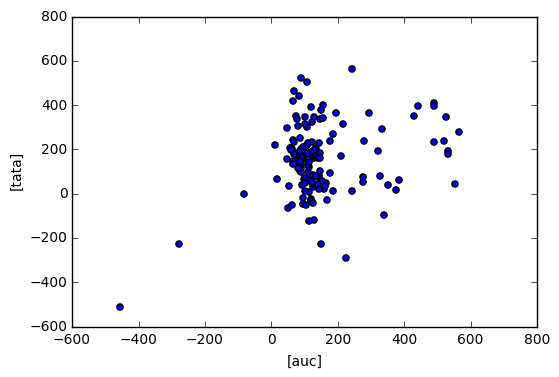

In [155]:

mix.plot.scatter(['auc'],['tata'])
print np.corrcoef(mix.auc, mix['count(TATA_distFromORF)'])[1][0]

In [414]:
prmt = {'@promoters':4030,'entire genome':12743}

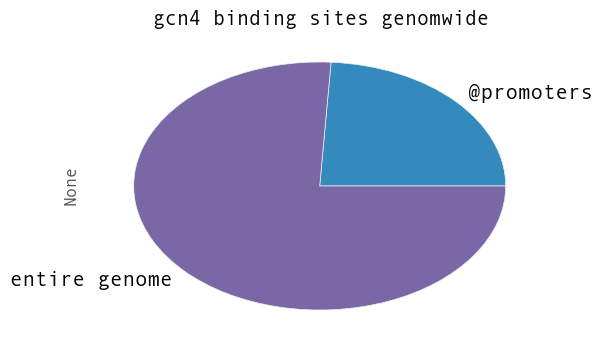

In [423]:
S = pd.Series(prmt).plot(kind='pie', fontsize=15)
plt.title('gcn4 binding sites genomwide')

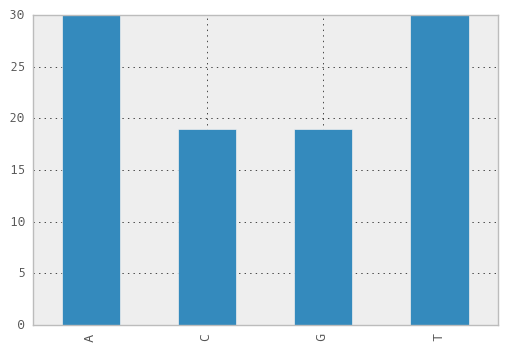

In [426]:
a,c,g,t = 3730181, 2313714, 2309288, 3718149
total = (a+c+g+t)/100
pd.Series({'A':a/total, 'C':c/total, 'G':g/total, 'T':t/total}).plot(kind='bar')
plt.title('Single strand proportion of nucleotides in genome vs @promoters')


In [25]:
genome_bp = pd.read_csv('ACGT_genome.csv')
genome_bp.set_index(['chromosome'], inplace=True)

In [26]:
genome_bp['norm_A'] = genome_bp['A']/genome_bp[['A','C','G','T']].sum(axis=1)*100
genome_bp['norm_C'] = genome_bp['C']/genome_bp[['A','C','G','T']].sum(axis=1)*100
genome_bp['norm_G'] = genome_bp['G']/genome_bp[['A','C','G','T']].sum(axis=1)*100
genome_bp['norm_T'] = genome_bp['T']/genome_bp[['A','C','G','T']].sum(axis=1)*100

In [27]:
#genome_bp[['norm_A','norm_C','norm_G','norm_T']]

([<matplotlib.axis.XTick at 0x7f5048d45dd0>,
 <a list of 15 Text xticklabel objects>)

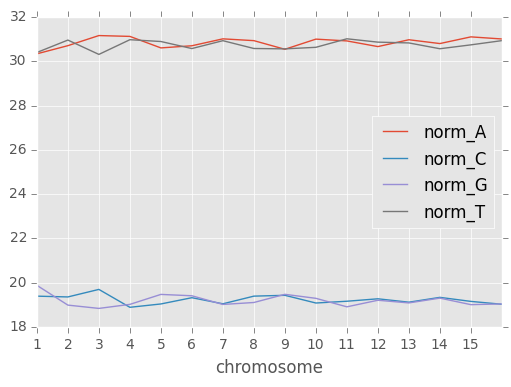

In [55]:
#import matplotlib
plt.style.use('ggplot')
#plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
genome_bp[['norm_A','norm_C','norm_G','norm_T']].plot()
plt.xticks(range(1,16))

In [35]:
print(matplotlib.style.available)

[u'dark_background', u'bmh', u'grayscale', u'ggplot', u'fivethirtyeight']


In [4]:
gcn4_BS_num = pd.read_csv('gcn4_BS_num.csv')
gcn4_BS_num = gcn4_BS_num[['id','count(gcn4_binding_sites_distFromORF)']]
gcn4_BS_num.columns = ['id','count']
gcn4_BS_num.set_index(['id'], inplace=True)

wig_counts = pd.read_csv('wig_totals.csv')
wig_counts = wig_counts[['id','area_14','reads_14','area_27','reads_27']]
wig_counts.set_index(['id'], inplace=True)


test = pd.concat([wig_counts['reads_14'],gcn4_BS_num], axis=1) 
#reads_14 	count


In [53]:
print test.count()
kkk=0
for i in test.itertuples():
    try:
        if (i.reads_14>10 and i.count>0) or (i.reads_14<10 and (i.count==0 or i.count==np.NaN)):
            kkk+=1
        
    except ValureError:
        print "go fuck yourself!!!"
        
print kkk

reads_14    6571
count       1296
dtype: int64
1274


In [33]:
test['reads'] = [0 for i in range(len(test))]
test['motifs'] = [0 for i in range(len(test))]

for i in test.itertuples():
    if i.reads_14>5000:
        test.loc[i.Index,'reads']=1

for i in test.itertuples():
    if pd.isnull(i.count)==False:
        test.loc[i.Index,'motifs']=1
    
print test[test.motifs==test.count].count()

reads_14    0
count       0
reads       0
motifs      0
dtype: int64


In [34]:
a = test[['motifs','reads']].dropna()

print a.count()
print a[((a.motifs==1) & (a.reads==1) | (a.motifs==0) & (a.reads==0))].count()
print a[((a.motifs==0) & (a.reads==1) | (a.motifs==1) & (a.reads==0))].count()

motifs    6571
reads     6571
dtype: int64
motifs    5193
reads     5193
dtype: int64
motifs    1378
reads     1378
dtype: int64


In [23]:
a.to_csv('R_M_binary.csv')

In [35]:
5193.0/6571.0*100

79.0290671130726